In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys, string, re, itertools, random 

#more_itertools, random
#from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn                                   

# # updates for nltk helper packages if needed
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
                                     
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive and feel about their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner.

## Data Understanding:
The data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions). From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th).

## Data Preparation I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<font size="4">We are going to look at the single missing tweet right now and save the nulls in the second column for later.</font>

## Checking the Null Tweet:
We have one null value in the `tweet` column we need to deal with.

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping the Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Renaming Columns:
The original names are a bit unwieldy.

In [9]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Shortening `emotion` Labels
Same reasoning as above.

In [10]:
df['emotion'] = df['emotion'].replace(['Negative emotion',
                                       'Positive emotion',
                                       'No emotion toward brand or product'],
                                      ['Negative',
                                       'Positive',
                                       'Neutral'])

## Checking for Duplicated Tweets:
If there are duplicated tweets, they probably won't add usefull information and most likely will be dropped.

In [11]:
# checking the shape baseline shape and saving it to a variable
original_shape = df.shape
original_shape

(9092, 3)

In [12]:
# filtering for dupes
dupes = df[df['tweet'].duplicated()]

In [13]:
# checking the number of dupes
len(dupes)

27

## Examining the Dupes:
Since there are only 27 dupes, we'll just examine all of them.

In [14]:
dupes

,tweet,brand_product,emotion
467,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
775,Google to Launch Major New Social Network Call...,NaN,Neutral
2231,Marissa Mayer: Google Will Connect the Digital...,NaN,Neutral
2558,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
3812,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive
3813,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive
3949,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive
3961,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
4896,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive
5337,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,Neutral


<font size="4">Other than the fact that there are a lot of retweets in the dupes, nothing else really stands out. Since we are losing only 27 rows of data, dropping seems like a safe decision.</font>

## Dropping Dupes

In [15]:
df.drop_duplicates(subset='tweet',inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
# comparing shapes
print(f'original shape: {original_shape}')
print(f'new shape: {df.shape}')

original shape: (9092, 3)
new shape: (9065, 3)


## Checking for Links:
Checking for url and {link} strings and getting a link count.

In [17]:
# checking for links
tweets = df['tweet']
links = fn.find_strings(tweets, r'(https*\S+)|(\{link\})')
print(links[:25])
len(links)

[[('http://ht.ly/49n4M', '')], [('http://bit.ly/ieaVOB', '')], [('http://bit.ly/gVLrIn', '')], [('http://j.mp/grN7pK)', '')], [('http://bit.ly/aXZwxB', '')], [('http://tinyurl.com/4nqv92l', '')], [('http://bit.ly/hTdFim', '')], [('http://t.co/kfN3f5Q', '')], [('http://t.co/g4GZypV', '')], [('http://tumblr.com/x6t1pi6av7', '')], [('http://bit.ly/hTdFim', '')], [('http://bit.ly/etsbZk', '')], [('http://t.co/A3xvWc6', '')], [('http://itunes.apple.com/us/app/holler-gram/id420666439?mt=8', '')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')]]


4175

<font size="4">Since these strings don't add sentiment information, we'll strip them out during the cleaning process.</font>

## Adding a Hashtag Column:
Hashtags have the potential to contain value information, so we'll create a new column to help explore them.

In [18]:
# copying hashtags to a new column and setting any empty lists to NaNs
df['hashtags'] = df['tweet'].apply(lambda x: 
                                   re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

In [19]:
# checking info & first 5 rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9065 non-null   object
 1   brand_product  3280 non-null   object
 2   emotion        9065 non-null   object
 3   hashtags       9065 non-null   object
dtypes: object(4)
memory usage: 283.4+ KB
None


,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,[#SXSW]


## Exploring the Hashtags
Creating a list and checking the length.

In [20]:
# creating a hashtag list
hashlists = df['hashtags'].tolist()

In [21]:
print(f'hashlists length: {len(hashlists)}')

hashlists length: 9065


In [22]:
hashlists[:5]

[['#RISE_Austin', '#SXSW'],
 ['#SXSW'],
 ['#iPad', '#SXSW'],
 ['#sxsw'],
 ['#SXSW']]

In [23]:
hash_counts = []
for listy in hashlists:
    hash_counts.append(len(listy))
print(f'total tags: {np.sum(hash_counts)}')
print(f'ave tags: {np.sum(hash_counts)/len(hash_counts)}')
print(f'max tags: {max(hash_counts)}')

total tags: 15779
ave tags: 1.7406508549365691
max tags: 12


<font size="5"> There are 15,779 hashtags.</font>

<font size="5"> The average number of hashtags per tweet is 1.74.</font>

<font size="5"> The maximum number of hashtags in a single tweet is 12.</font>

<font size ="5"> Below is the tweet with the max number of hashtags and a list of the hashtags.</font>

In [24]:
print(df.iloc[np.argmax(hash_counts)][0])

print(hashlists[np.argmax(hash_counts)])

iPad 2 and Its Rivals: How They Stack Up {link} #bnet #biz #ipad2 #apple #sxsw #ipad #tablet #xoom #tech #laptop #pics #sale
['#bnet', '#biz', '#ipad2', '#apple', '#sxsw', '#ipad', '#tablet', '#xoom', '#tech', '#laptop', '#pics', '#sale']


## Checking for Empty Lists & Converting to NaNs
Converting and checking length.

In [25]:
df['hashtags'] = df['hashtags'].apply(lambda x: np.nan if len(x) == 0 else x)

In [26]:
df['hashtags'].isna().sum()

10

## Checking Tweets with no Hashtags
There are 10 tweets that don't have a hashtag that we'll examine.

In [27]:
df[df['hashtags'].isna()]

,tweet,brand_product,emotion,hashtags
307,And a few are Android too RT @mention 10 New M...,Android App,Positive,NaN
471,"Before It Even Begins, Apple WinsåÊ#SxSW, {lin...",Apple,Positive,NaN
768,Google to Launch Major New Social Network Call...,Google,Positive,NaN
791,Google to Launch Major New Social Network Call...,NaN,Neutral,NaN
930,To buy or not to buy RT @mention Before It Eve...,Apple,Positive,NaN
1139,ÛÏ@mention The 10 most dangerous IPhone apps....,NaN,Neutral,NaN
2427,Extra iPad 2 for sale in Austin convention cen...,NaN,Neutral,NaN
3477,GENIUS behind Google Circles.\n¡á¾_Î¾Ð¡____...,Other Google product or service,Positive,NaN
5015,RT @mention,NaN,Neutral,NaN
5538,"RT @mention Before It Even Begins, Apple Winså...",Apple,Positive,NaN


<font size="4">It doesn't appear that there is any pattern to the tweets with no hashtags.</font>

## Checking the Hashtag Set
Removing NaNs, making a list, converting to lowercase and forming a set.

In [28]:
# removing Nans
hashlists = df.hashtags.tolist()
hashlists = [h_list for h_list in hashlists if str(h_list) != 'nan']

In [29]:
# checking length
len(hashlists)

9055

In [30]:
# unpacking hashtags & lowercasing
hashtags = [hashtag.lower() for h_list in hashlists for hashtag in h_list]

In [31]:
# checking work
hashtags[:5]

['#rise_austin', '#sxsw', '#sxsw', '#ipad', '#sxsw']

In [32]:
# making a set and checking length
len(set(hashtags))

1460

<font size="4">There are 1,460 unique hashtags.</font>

## Visualizing the Top 20 Hashtags
Graphing the counts and frequencies of the top 20 hashtags.

In [33]:
# creating a dataframe for the plots
hts = pd.DataFrame(hashtags, columns=['hashtags'])

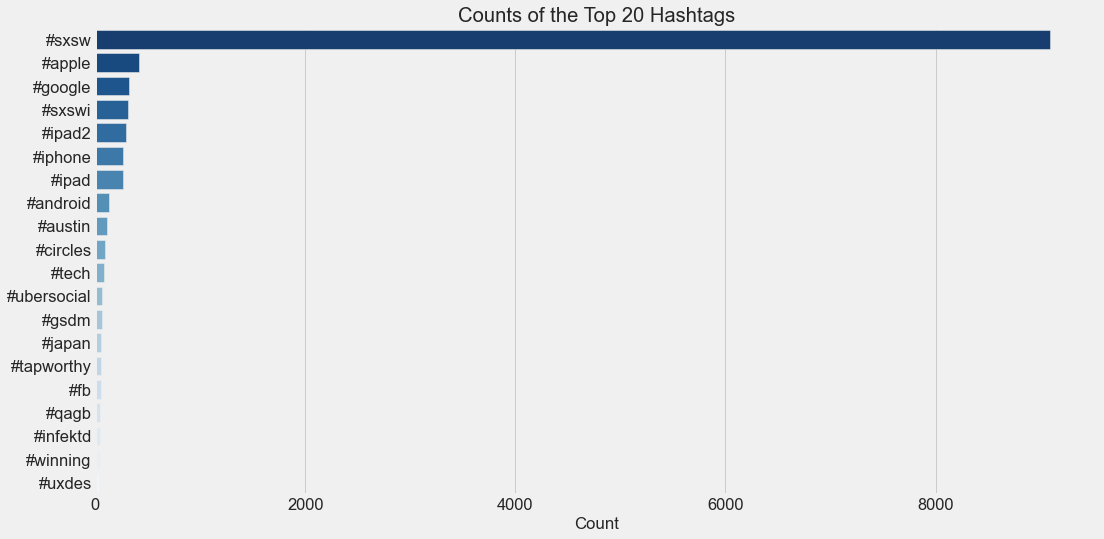

In [34]:
vz.hashtag_c(hts)

In [35]:
hts['hashtags'].value_counts()[:20]

#sxsw          9087
#apple          416
#google         321
#sxswi          316
#ipad2          296
#iphone         265
#ipad           264
#android        131
#austin         112
#circles         98
#tech            87
#ubersocial      68
#gsdm            64
#japan           58
#tapworthy       54
#fb              52
#qagb            50
#infektd         48
#winning         44
#uxdes           40
Name: hashtags, dtype: int64

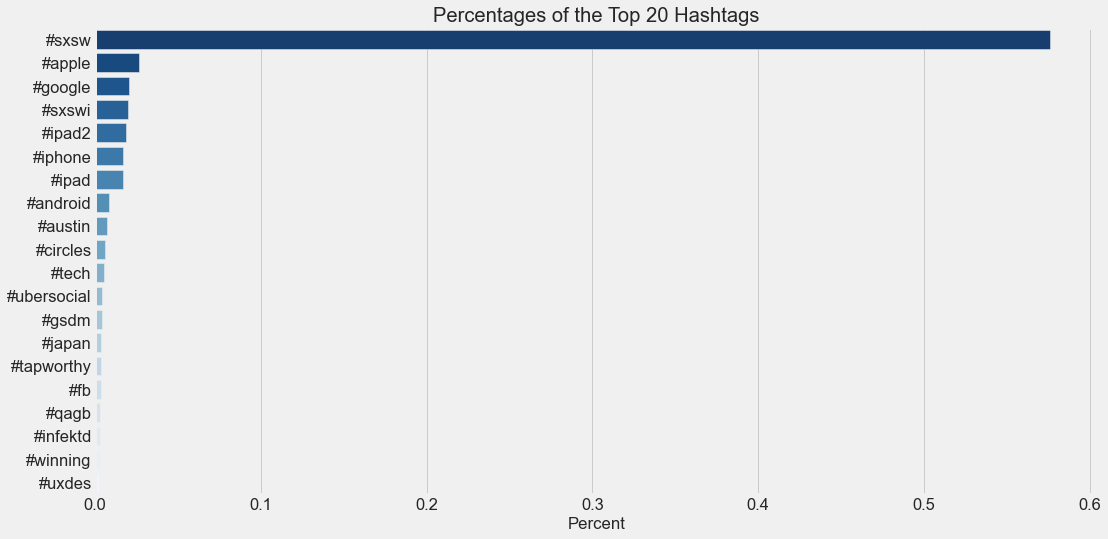

In [36]:
vz.hashtag_p(hts)

In [37]:
hts['hashtags'].value_counts(normalize=True)[:20]

#sxsw          0.575892
#apple         0.026364
#google        0.020343
#sxswi         0.020027
#ipad2         0.018759
#iphone        0.016794
#ipad          0.016731
#android       0.008302
#austin        0.007098
#circles       0.006211
#tech          0.005514
#ubersocial    0.004310
#gsdm          0.004056
#japan         0.003676
#tapworthy     0.003422
#fb            0.003296
#qagb          0.003169
#infektd       0.003042
#winning       0.002789
#uxdes         0.002535
Name: hashtags, dtype: float64

<font size="4">We can see from the graphs above that the vast majority (58%) of the hashtags are `#sxsw`. Every other hashtag is less than 2.7% of the total number of hashtags.</font>

## Checking for RTs
Collecting the retweets checking the count. 

In [38]:
RTs = fn.find_strings(df['tweet'], '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [39]:
RTs[:5]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention']]

In [40]:
len(RTs)

2551

<font size="4"> There are 2551 retweets. </font>

## Checking for Mentions
Collecting the mentions checking the count

In [41]:
ats = fn.find_strings(df['tweet'], '@[A-Za-z]+[A-Za-z0-9-_]+')
ats[:5]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate']]

In [42]:
len(ats)

4903

<font size="4"> There are 4903 mentions. </font>

## Checking Brand/Product Counts and Frequencies

In [43]:
len(df.brand_product.unique())

10

<font size="4">The are 10 unique values in the `Brand/Product` column including `NaN`.</font>

In [44]:
df.brand_product.isna().sum()/df.shape[0]

0.6381687810259239

<font size="4">63% of the rows have null values in the `Brand/Product` column.</font>

In [45]:
df.brand_product.value_counts().sum()/df.shape[0]

0.3618312189740761

<font size="4">36% of rows have non-null brand data.</font >

In [46]:
df.brand_product.value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: brand_product, dtype: float64

In [47]:
idx = [0, 1, 2, 4, 8]
sum = 0
for i in idx:
    sum += df.brand_product.value_counts(normalize=True)[i]
sum

0.7323170731707316

<font size="4">The Apple brand and Apple products account for 73% of the brand data.</font>

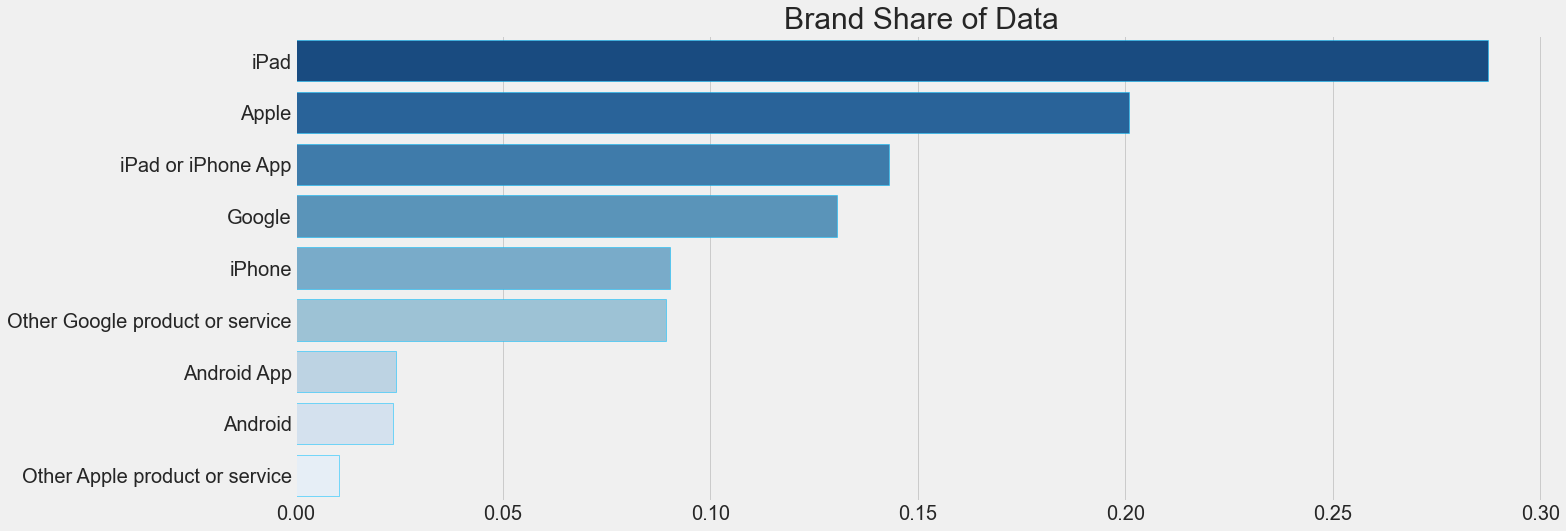

In [48]:
vz.brand_freqs(df)

<font size="4"> The graph above confirm Apple's predominance in the `Brand/Product` column. </font>

## Checking Emotion Unique Values

In [49]:
len(df.emotion.unique())

4

<font size="4">There are 4 unique values in the emotion category.</font>

In [50]:
df.emotion.value_counts()

Neutral         5372
Positive        2968
Negative         569
I can't tell     156
Name: emotion, dtype: int64

In [51]:
df.emotion.value_counts(normalize=True)

Neutral         0.592609
Positive        0.327413
Negative        0.062769
I can't tell    0.017209
Name: emotion, dtype: float64

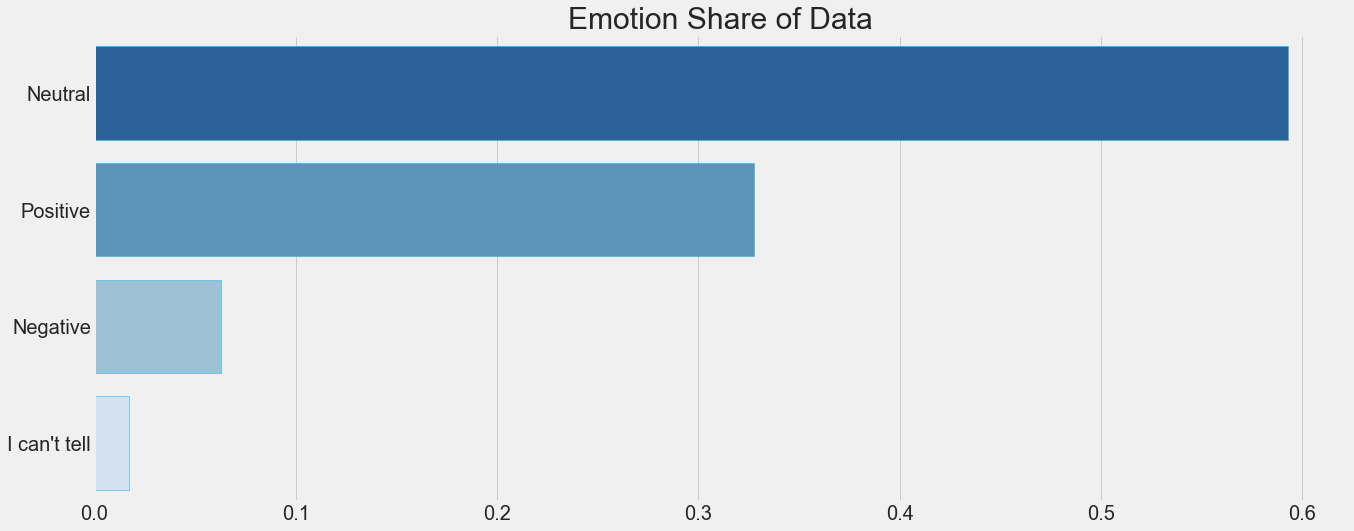

In [52]:
vz.emotion_freqs(df)

<font size="4">`No emotion` accounts for 59% of the data.</font>

<font size="4">`Positive emotion`                   accounts for 33% of the data.</font>

<font size="4">`Negative emotion`                   accounts for 6% of the data.</font>

<font size="4">`I can't tell`                       accounts for 2% of the data.</font>

<font size="4">We want to be able to detect the emotional sentiment of the tweets so we'll drop the `I can't tell` labels.</font>

In [53]:
# getting the original number of rows
before = df.shape[0]

# saving number of 'can't tell' rows
num_cant_tell =df.emotion.value_counts()[3]

# dropping the 'can't tell' rows
df = df[~(df['emotion']=='I can\'t tell')]

# resetting index
df.reset_index(drop=True, inplace=True)

# checking that the number of rows dropped match the number of 'can't tell' rows
before - df.shape[0] == num_cant_tell

True

## Emotions by Brand

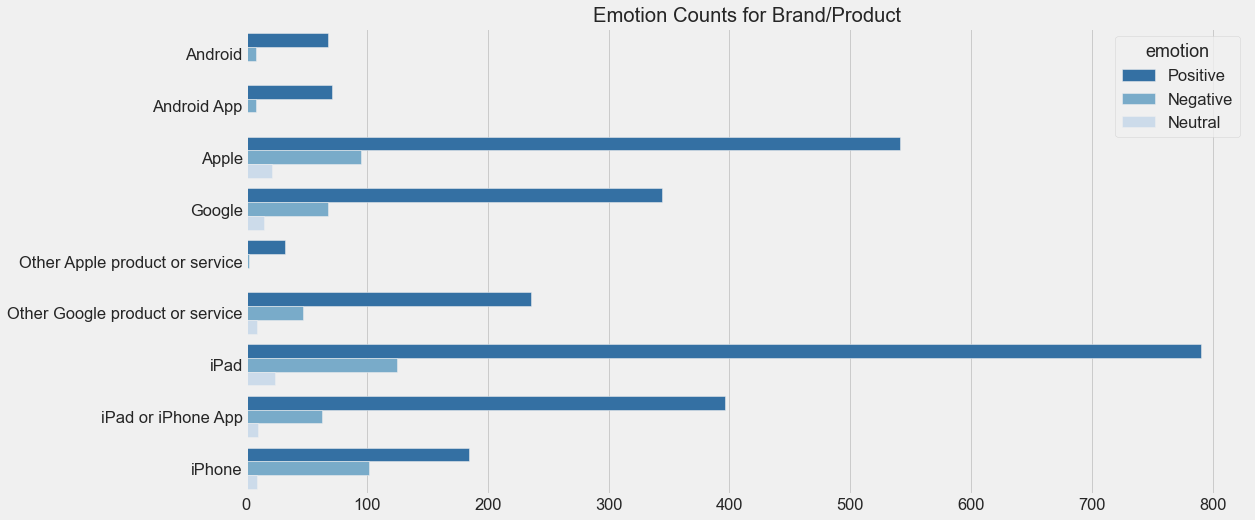

In [54]:
vz.brand_emotions(df)

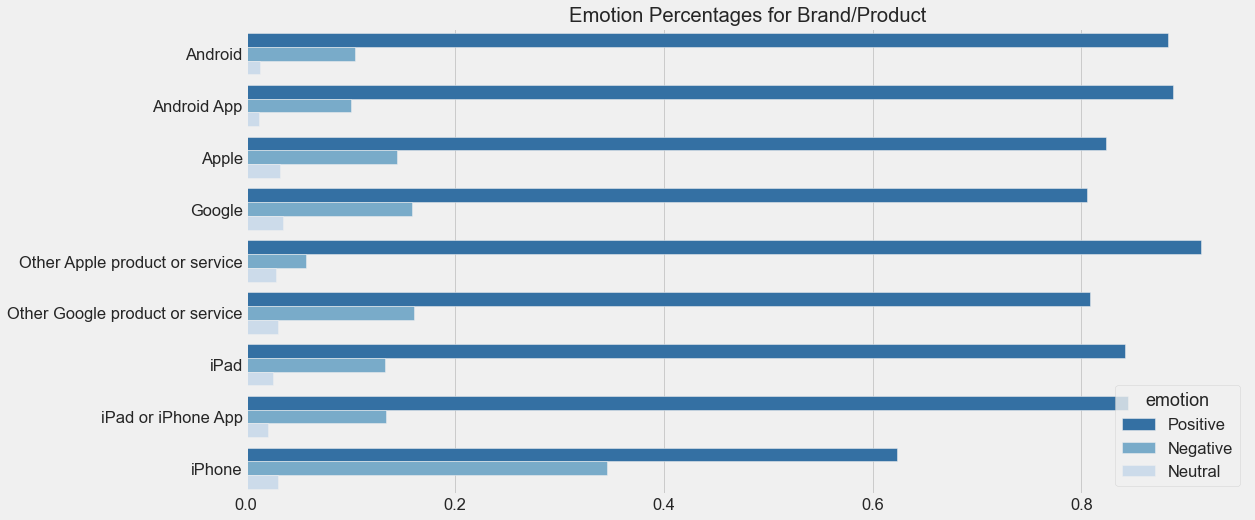

In [55]:
vz.brand_emotion_n(df)

## Checking Nulls in Product Column

In [56]:
product_nulls = df[df['brand_product'].isnull()]

In [57]:
product_nulls.head()

,tweet,brand_product,emotion,hashtags
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral,"[#SpeechTherapy, #SXSW, #iear, #edchat, #asd]"
15,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral,[#sxsw]
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral,"[#SXSW, #GDGTLive]"
32,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral,[#sxsw]
33,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral,[#SXSW]


In [58]:
product_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5638 entries, 5 to 8908
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          5638 non-null   object
 1   brand_product  0 non-null      object
 2   emotion        5638 non-null   object
 3   hashtags       5634 non-null   object
dtypes: object(4)
memory usage: 220.2+ KB


In [59]:
product_nulls['emotion'].value_counts()

Neutral     5281
Positive     306
Negative      51
Name: emotion, dtype: int64

## Checking Null Brands Emotion Data

In [60]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'Neutral')]

In [61]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 45 to 8872
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          357 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        357 non-null    object
 3   hashtags       357 non-null    object
dtypes: object(4)
memory usage: 13.9+ KB


In [62]:
null_brand_emotions.head()

,tweet,brand_product,emotion,hashtags
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive,[#SXSW]
63,Again? RT @mention Line at the Apple store is ...,NaN,Negative,[#sxsw]
67,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative,[#sxsw]
100,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative,[#sxsw]
109,Spark for #android is up for a #teamandroid aw...,NaN,Positive,"[#android, #teamandroid, #SXSW]"


## Null Brand Emotion Counts

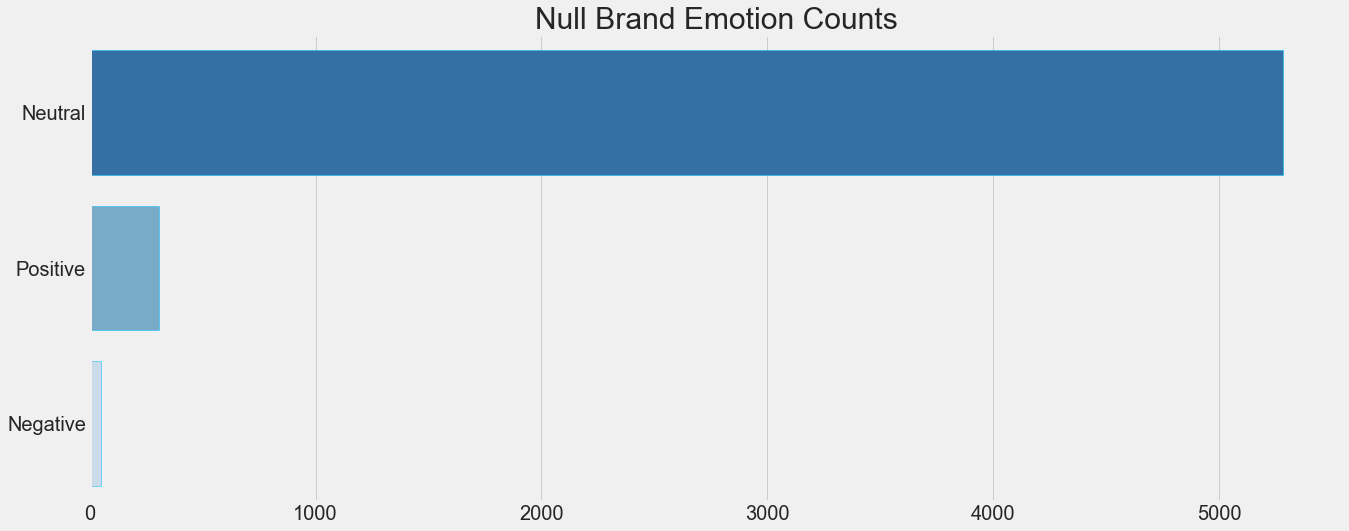

In [63]:
vz.null_brand_emotions(df)

## Examining Some Null Brand Tweets

In [64]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [65]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [66]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


## Data Preparation II: (Cleaning the Data)
The master cleaning functions remove punctuation, urls, retweets, mentions, other unwanted substrings ('{link}', &amp, &quot, &nbsp, &lt, &gt), lower case all letters, and return a list of clean and regularized (lemmas or stems) tweets.

In [67]:
data_clean_lemmas = fn.clean_corpus_lem(df.tweet)

In [68]:
data_clean_stems = fn.clean_corpus_stem(df.tweet)

## Comparing Raw Tweets to the Cleaned & Regularized Tweets

In [69]:
for i in range(100):
    print(f'original: {df.tweet[i]}\n')
    print(f'lemms: {data_clean_lemmas[i]}')
    print(f'stems: {data_clean_stems[i]}\n')

original: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.

lemms: 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw
stems: 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw

original: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW

lemms: know awesome ipad iphone app likely appreciate design also giving free t sxsw
stems: know awesom ipad iphon app like appreci design also give free ts sxsw

original: @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.

lemms: wait ipad 2 also sale sxsw
stems: wait ipad 2 also sale sxsw

original: @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw

lemms: hope year festival crashy year iphone app sxsw
stems: hope year festiv crashi year iphon app sxsw

original: @sxtxstate great st

<font size="4">Looks good, so we''ll add the lemmatized and stemmed tweets  to the data frame as columns.</font>

In [70]:
df['lemmas'] = data_clean_lemmas

In [71]:
df['stems'] = data_clean_stems

In [72]:
df.head()

,tweet,brand_product,emotion,hashtags,lemmas,stems
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,"[#RISE_Austin, #SXSW]",3g iphone 3 hr tweeting rise austin dead need ...,3g iphon 3 hr tweet rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,[#SXSW],know awesome ipad iphone app likely appreciate...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,"[#iPad, #SXSW]",wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,[#sxsw],hope year festival crashy year iphone app sxsw,hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,[#SXSW],great stuff fri sxsw marissa mayer google tim ...,great stuff fri sxsw marissa mayer googl tim r...


## Making the `emotion` Target Ternary

In [73]:
df.emotion.value_counts()

Neutral     5372
Positive    2968
Negative     569
Name: emotion, dtype: int64

In [74]:
df['emotion'] = df['emotion'].replace(['Negative',
                                       'Positive',
                                       'Neutral'],
                                       [0, 1, 2])

In [75]:
df['emotion'].value_counts()

2    5372
1    2968
0     569
Name: emotion, dtype: int64

In [76]:
df.head()

,tweet,brand_product,emotion,hashtags,lemmas,stems
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,"[#RISE_Austin, #SXSW]",3g iphone 3 hr tweeting rise austin dead need ...,3g iphon 3 hr tweet rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,[#SXSW],know awesome ipad iphone app likely appreciate...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,"[#iPad, #SXSW]",wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,[#sxsw],hope year festival crashy year iphone app sxsw,hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,[#SXSW],great stuff fri sxsw marissa mayer google tim ...,great stuff fri sxsw marissa mayer googl tim r...


## Moving the Target and Regularized Columns to the Front of the Data Frame

In [77]:
cols = ['lemmas', 'stems', 'emotion']

for col in cols:
    c = df.pop(col)
    df.insert(0, col, c)
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,0,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"[#RISE_Austin, #SXSW]"
1,1,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,[#SXSW]
2,1,wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"[#iPad, #SXSW]"
3,0,hope year festiv crashi year iphon app sxsw,hope year festival crashy year iphone app sxsw,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,[#sxsw]
4,1,great stuff fri sxsw marissa mayer googl tim r...,great stuff fri sxsw marissa mayer google tim ...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,[#SXSW]


## Exporting the Ternary Data for Modeling

In [78]:
# path = os.path.join(gparent, 'data/processed', 'modeling_ternary.csv')
# df.to_csv(path, index=False)

## EDA on Clean, Regularized Data

## Frequency Distributions of Raw vs Cleaned Data

#### Raw Data

In [79]:
fn.word_frequencies(df.tweet, 30)

Word 			Frequency

sxsw      		0.0843    
mention   		0.0625    
link      		0.0379    
rt        		0.026     
google    		0.0232    
ipad      		0.0221    
apple     		0.0205    
quot      		0.0148    
iphone    		0.0138    
store     		0.0131    
2         		0.0105    
new       		0.0096    
austin    		0.0085    
amp       		0.0074    
app       		0.0073    
social    		0.0058    
circles   		0.0058    
launch    		0.0057    
android   		0.0053    
pop       		0.0052    
today     		0.0051    
ipad2     		0.0041    
network   		0.004     
via       		0.0038    
line      		0.0036    
get       		0.0035    
free      		0.0035    
party     		0.0031    
called    		0.0031    
mobile    		0.0031    


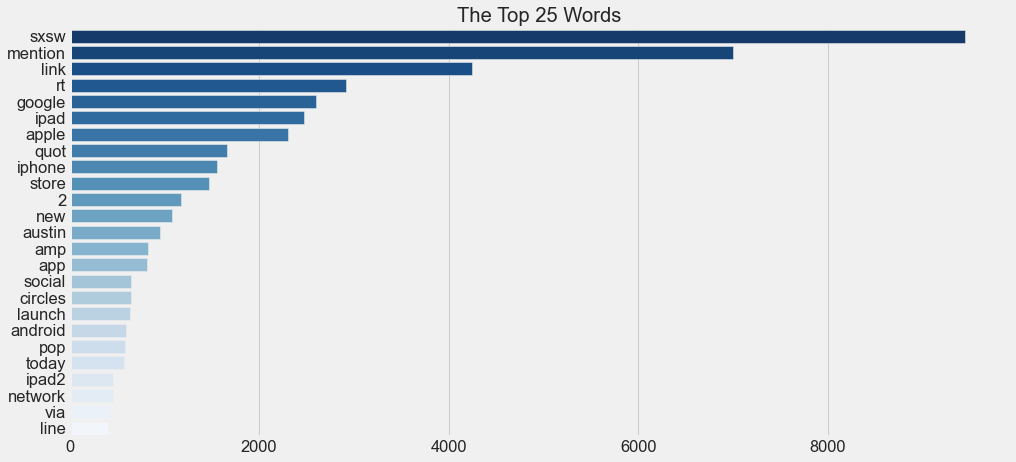

In [80]:
raw_words = fn.words(df.tweet)
vz.top_word_list(raw_words, 25)

<font size="4"> SXSW is by far the most prevalent value, and we can see the 4 out of the top 5 words are unrelated to the relevant brands.</font>

#### Lemmatized Data

In [81]:
fn.word_frequencies(df.lemmas, 25)

Word 			Frequency

sxsw      		0.0993    
google    		0.0273    
ipad      		0.0261    
apple     		0.0242    
iphone    		0.0163    
store     		0.0158    
2         		0.0127    
new       		0.0113    
austin    		0.0101    
app       		0.0086    
launch    		0.0071    
circle    		0.007     
social    		0.0068    
android   		0.0062    
pop       		0.0062    
today     		0.006     
network   		0.0048    
ipad2     		0.0048    
get       		0.0048    
line      		0.0046    
via       		0.0045    
party     		0.0042    
free      		0.0041    
mobile    		0.0037    
called    		0.0036    


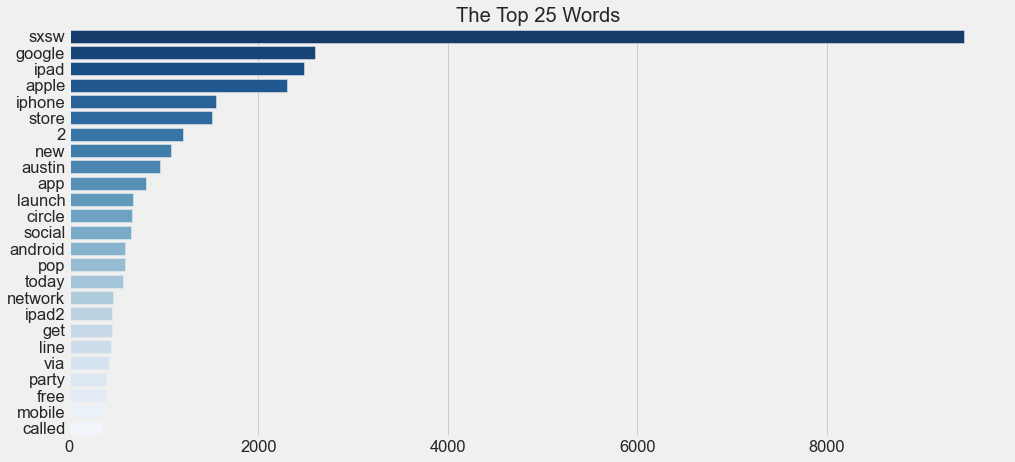

In [82]:
lemm_words = fn.words(df.lemmas)
vz.top_word_list(lemm_words, 25)

<font size="4"> SXSW still predominates, but the other 4 in the top 5 are now relevant to the brands.</font>

#### Stemmed Data

In [83]:
fn.word_frequencies(df.stems, 25)

Word 			Frequency

sxsw      		0.0994    
googl     		0.0274    
ipad      		0.027     
appl      		0.0242    
iphon     		0.0164    
store     		0.0159    
2         		0.0124    
new       		0.0113    
app       		0.011     
austin    		0.0101    
launch    		0.0087    
circl     		0.007     
social    		0.0069    
pop       		0.0063    
android   		0.0062    
today     		0.006     
open      		0.0056    
get       		0.0056    
network   		0.005     
ipad2     		0.005     
line      		0.0048    
via       		0.0045    
go        		0.0044    
parti     		0.0042    
free      		0.0041    


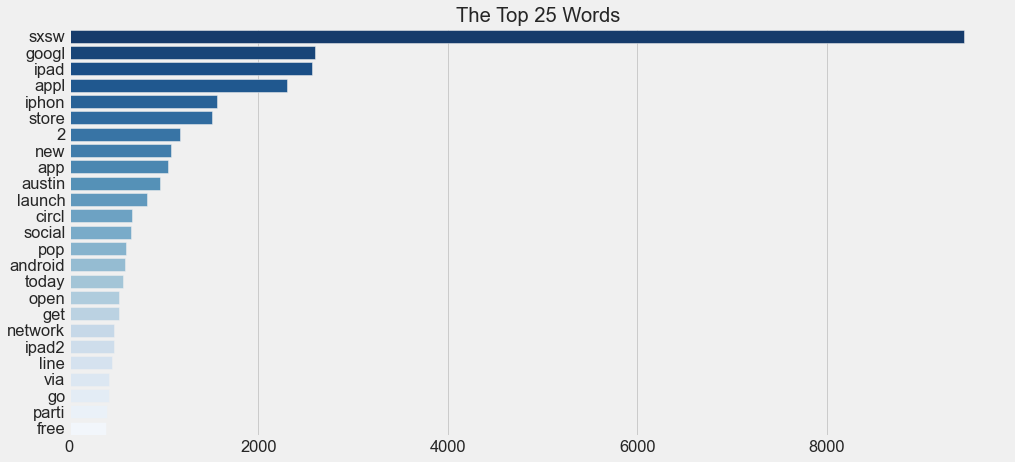

In [84]:
stem_words = fn.words(df.stems)
vz.top_word_list(stem_words, 25)

<font size="4"> Again, SXSW dominates, but the rest of the top 4 relate to the relevant brands.</font>

## Vocabularies

#### Lemmas Vocabulary

In [85]:
lemma_vocab = fn.vocabulary(data_clean_lemmas)

In [86]:
# checking number of words
len(lemma_vocab)

8636

In [87]:
# first 100 words
for i, val in enumerate(itertools.islice(lemma_vocab, 100)):
    print(val)

zynga
pub
ipads
localmind
iear
functionality
pst
liveley
salon
chasing
tonchidot
intel
industrialdesign
tonigh
geeksrule
ripping
futureofed
yr
occasion
living
synced
popplet
topicality
heart
cop
psfk
uploaded
pledge
standard
sapo
mymom
versione
4
msusxsw
unpaid
cup
och
tahoe
articulate
4sqchat
begin
publicly
icenhaur
man
merchant
spasmatics
clover
yet
la
story
providing
cheapen
source
gamesalad
parra
copper
twit
rendering
istock
customized
somehow
chair
interoperability
lb
initiate
web3
startupbus
hopefully
spreadsheet
mag
fuckyeah
slightly
exploring
evan
outoftheloop
proper
summary
sheeple
artistic
microformats
worm
consumption
gsd
cera
sqft
tokii
12
ultimate
setup
detect
carpet
8800
ie
stuck
mindtouchers
publicradio
part
fine
i7
mixtape


In [88]:
# random 100 words
for i, val in enumerate(random.sample(lemma_vocab, 100)):
    print(val)

familiarize
ifr3dw
also
angrybirds
medium
donut
clone
download
sack
43
analytics
relatable
kit
guess
tiny
removable
pulse
investor
shy
challenged
omega
ausxsw
activate
ben
liked
parenthesis
unconvinced
acceptable
anymore
lucky
tamale
idea
pull
lowest
dwindling
gatorade
respectfully
expand
booya
gaga
shame
barton
character
bluezoom
unexpected
searchable
payitforward
install
portion
90
compilation
choose
dslr
transitapps
rm
dog
pump
flypost
turnstone
evri
prime
andoid
ate
grew
disagree
dope
austinwins
hype
tme
svcs
puregenius
bajillions
headset
responsibility
qualifies
globalbestaward
overall
sim
futureofed
confusion
toe
gap
acknowledge
circle
605
11pm
clock
nfb
within
imparted
context
void
18
stealing
win
protection
employee
wonderful
bemyneighbor
strum


In [89]:
fn.string_checker(lemma_vocab, 'https')
fn.string_checker(lemma_vocab, 'madebymany')

string is not in data
string is in data


#### Stems Vocabulary

In [90]:
stemma_vocab = fn.vocabulary(data_clean_stems)

In [91]:
# number of words
len(stemma_vocab)

7342

In [92]:
# first 100 words
for i, val in enumerate(itertools.islice(stemma_vocab, 100)):
    print(val)

zynga
pub
localmind
iear
pst
liveley
salon
tonchidot
intel
industrialdesign
tonigh
yr
occasion
popplet
bu
heart
cop
psfk
proce
standard
sapo
mymom
laker
pictionari
4
appropri
exactli
msusxsw
unpaid
cup
och
4sqchat
begin
icenhaur
man
merchant
clover
yet
la
disgrac
crashi
dotright
cheapen
gamesalad
parra
copper
twit
gadgetenvi
istock
somehow
chair
lb
reportedli
web3
austinj
spreadsheet
mag
fuckyeah
ungrat
outoftheloop
evan
proper
worm
singl
gsd
cera
sqft
tokii
12
setup
detect
carpet
8800
ie
coffe
tronlegaci
stuck
publicradio
part
fine
mindshar
ramp
i7
moot
pvhous
cocoon
thirsti
000
drumbeat
refer
wilt
tnx
wild
hunt
stabil
vast
dan
persist
musicviz
eg


In [93]:
# random 100 words
for i, val in enumerate(random.sample(stemma_vocab, 100)):
    print(val)

jr
richard
sight
2rd
lt
jinx
thanksforthebrandedshad
would
angrybird
wannab
contribut
cynic
eurorscg
learnt
mania
donkey
darknet
dongl
bettercloud
elonsxsw
141st
guilti
punchout
xplat
amismarternow
power
ahold
hyatt
natur
bro
window
spazzmat
klick
umm
attn
samsungsxsw
achiev
flip
smarter
layar
keepingupwithdkm
fuckit
smoke
surgeri
thoma
checkout
ver
franken
darn
swimsuit
gabacustweet
at038t
finder
cup
pluck
fewer
dawg
bio
revamp
virtualwallet
glass
douch
net
issu
icross
hannukah
main
suggest
lanyrd
cnn
sundayswagg
succeed
io
woefulli
advis
leg
e
commun
beechwood
milyoni
diari
parakeet
hollrback
96
childish
condesa
mock
ambl
harhar
htxsw
regular
superbia
view
tablet
rechristen
exploit
song
comm
dwell
b4


In [94]:
fn.string_checker(stemma_vocab, 'https')
fn.string_checker(stemma_vocab, 'madebymany')

string is not in data
string is not in data


## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [95]:
# filtering
binary_data = df[(df['emotion'] == 0) |\
                 (df['emotion'] == 1)].copy()

In [96]:
# resetting the index
binary_data.reset_index(drop=True, inplace=True)

In [97]:
# checking the first five rows
binary_data.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,0,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"[#RISE_Austin, #SXSW]"
1,1,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,[#SXSW]
2,1,wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"[#iPad, #SXSW]"
3,0,hope year festiv crashi year iphon app sxsw,hope year festival crashy year iphone app sxsw,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,[#sxsw]
4,1,great stuff fri sxsw marissa mayer googl tim r...,great stuff fri sxsw marissa mayer google tim ...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,[#SXSW]


In [98]:
# checking the info
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


In [99]:
# checking for nulls
binary_data.isna().sum()

emotion            0
stems              0
lemmas             0
tweet              0
brand_product    357
hashtags           6
dtype: int64

In [100]:
# checking the value counts
binary_data['emotion'].value_counts()

1    2968
0     569
Name: emotion, dtype: int64

## Exporting the Binary Data for Modeling

In [101]:
# path = os.path.join(gparent, 'data/processed', 'modeling_binary.csv')
# binary_data.to_csv(path, index=False)